In [ ]:
from dask.distributed import Client

client = Client("gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.8625e1065d04441bb2ec1e9c00f6a560")
client

In [1]:
# Set to have less messages from distributed
import dask
dask.config.set({"logging.distributed": "error"})

In [2]:
from dask.distributed import Client

client = Client("tcp://10.32.10.8:46485")
client

OSError: Timed out trying to connect to 'tcp://10.32.10.8:46485' after 10 s: Timed out trying to connect to 'tcp://10.32.10.8:46485' after 10 s: connect() didn't finish in time

In [1]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [5]:
coords = (cat.LLC4320_grid.to_dask())

In [8]:
XCcoarse = coords.XC.coarsen(i=40, j=40).mean()
YCcoarse = coords.YC.coarsen(i=40, j=40).mean()

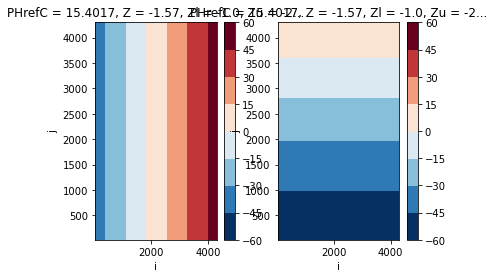

In [9]:
plt.subplot(121)
XCcoarse.isel(face=1).plot.contourf(levels=10)

plt.subplot(122)
YCcoarse.isel(face=1).plot.contourf(levels=10)

In [10]:
Xmin = XCcoarse.min(['i','j'])
Xmax = XCcoarse.max(['i','j'])

Ymin = YCcoarse.min(['i','j'])
Ymax = YCcoarse.max(['i','j'])

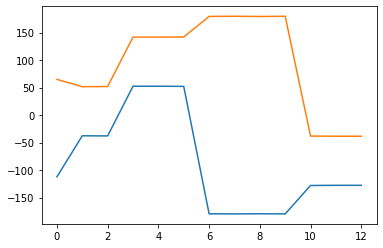

In [12]:
plt.plot(Xmin)
plt.plot(Xmax)

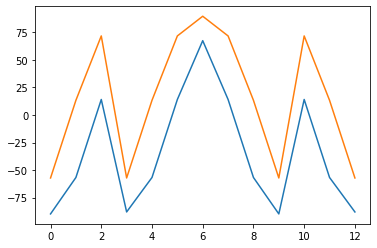

In [13]:
plt.plot(Ymin)
plt.plot(Ymax)

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

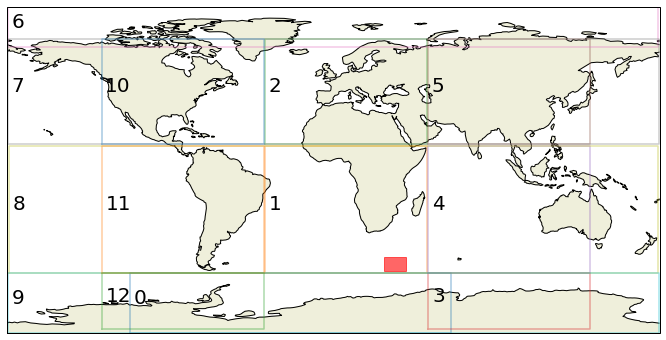

In [15]:

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

#ax.plot(x, y, marker='o', transform=ccrs.PlateCarree())
for i in range(0,13):
    Xface = [Xmin.isel(face=i), Xmax.isel(face=i), Xmax.isel(face=i), Xmin.isel(face=i), Xmin.isel(face=i)]
    Yface = [Ymin.isel(face=i), Ymin.isel(face=i), Ymax.isel(face=i), Ymax.isel(face=i), Ymin.isel(face=i)]
    
    Xmid = Xmin.isel(face=i)+2
    Ymid = 0.5*(Ymin.isel(face=i) + Ymax.isel(face=i))
    
    ax.plot(Xface, Yface, transform=ccrs.PlateCarree(), alpha=0.4)
#    ax.fill(Xface, Yface, transform=ccrs.PlateCarree(), alpha=0.4)
    ax.text(Xmid, Ymid, i, fontsize=20, transform=ccrs.PlateCarree())


x_sogos, y_sogos = [28, 40, 40, 28, 28], [-56, -56, -48, -48, -48]
ax.fill(x_sogos, y_sogos, color='red', transform=ccrs.PlateCarree(), alpha=0.6)

ax.coastlines()
ax.set_boundary
ax.add_feature(cfeature.LAND)
#ax.gridlines(draw_labels=True);

# The rotated U,V velocities 
The u,v velocities on the latlon grid face in the direction of i and j, and not the true east and north. It is particularly confusing because the variable's u and v are still referred to as zonal and meridional velocities in the attributes. This is particularly a concern when dealing with the facenumbers 6-12. 
This issue is discussed here: https://github.com/MITgcm/xmitgcm/issues/204 

The thing I want to test here is whether the to_latlon feature of llcreader allows

In [14]:
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()
SST = cat.LLC4320_SST.to_dask()
coords = cat.LLC4320_grid.to_dask()

In [4]:
u_face2 = u.isel(time=0).sel(face=2).coarsen(i_g=40, j=40).mean()
v_face2 = v.isel(time=0).sel(face=2).coarsen(i=40, j_g=40).mean()

In [31]:
u_face10 = u.isel(time=0).sel(face=10).coarsen(i_g=40, j=40).mean()
v_face10 = v.isel(time=0).sel(face=10).coarsen(i=40, j_g=40).mean()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


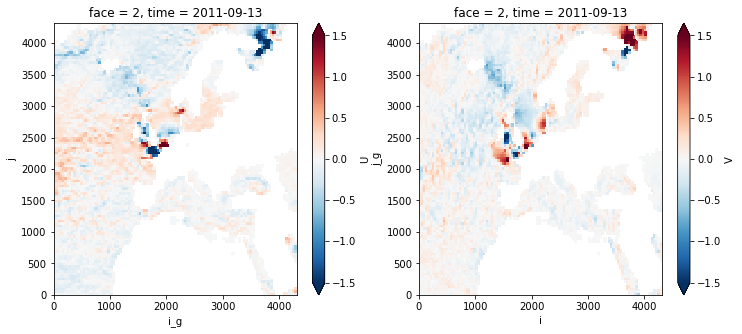

In [30]:
plt.figure(figsize=(12,5))
plt.subplot(121)
u_face2.U.plot(vmin=-1.5)

plt.subplot(122)
v_face2.V.plot(vmin=-1.5)


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


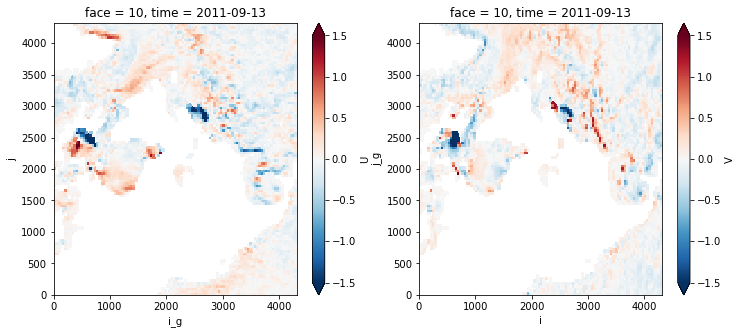

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(121)
u_face10.U.plot(vmin=-1.5)

plt.subplot(122)
v_face10.V.plot(vmin=-1.5)

# notice that in the western NAtl the strong zonal jet of the gulfstream 
# is visible in the "meridional" velocity. 

In [15]:
ds = xr.merge([u, v, SST, coords])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    Zu       float32 ...
    drC      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      float32 ...
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacC    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacS    (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacW    (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    k        int64 ...
    k_l      int64 ...
  * k_p1     (k_p1) int64 0 1
    k_u      int64 ...
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    U        (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    V        (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [7]:
sel_atl = np.logical_and(np.logical_and(ds.XC>-80, ds.XC<0 ), 
                           np.logical_and(ds.YC>12, ds.YC<50 ))

In [18]:
import xgcm
grid = xgcm.Grid(ds.drop(['k', 'k_p1']), periodic=None)

In [19]:
grid

<xgcm.Grid>
T Axis (not periodic):
  * center   time
Y Axis (not periodic):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic):
  * center   i --> left
  * left     i_g --> center

In [20]:
# Select out the north atlantic
U_sel = (grid.interp(ds.U, 'X', boundary='extend')
        ).where(sel_atl, drop=True).rename('U')

In [21]:
V_sel = (grid.interp(ds.V, 'Y', boundary='extend')
        ).where(sel_atl, drop=True).rename('V')

In [25]:
U_sel_coarse= U_sel.isel(time=0).coarsen(i=40, j=40, boundary='trim').mean()
V_sel_coarse= V_sel.isel(time=0).coarsen(i=40, j=40, boundary='trim').mean()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Zonal velocity')

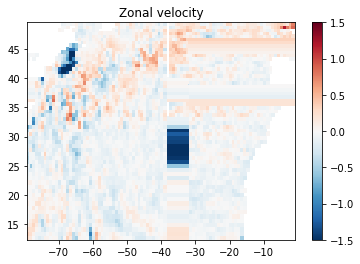

In [37]:
plt.pcolormesh(U_sel_coarse.XC, U_sel_coarse.YC, U_sel_coarse, 
               vmin=-1.5, vmax=1.5, cmap="RdBu_r")
plt.colorbar()
plt.title('Zonal velocity')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Meridional velocity')

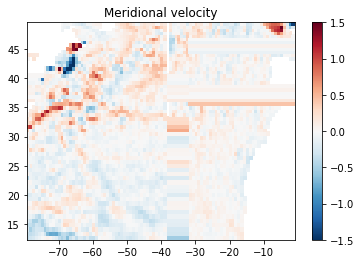

In [38]:
plt.pcolormesh(V_sel_coarse.XC, V_sel_coarse.YC, V_sel_coarse, 
               vmin=-1.5, vmax=1.5, cmap="RdBu_r")
plt.colorbar()
plt.title('Meridional velocity')

## Conclusions about velocities 
It seems that even though faces_dataset_to_latlon stitches the faces togethe onto a lat-lon grid. It is not actually rotating the velocities appropriately. 
>The zonal jet of the Gulf Stream is appearing in the meridional velocities instead of the zonal. 

Plotting these connected faces together seems to be problematic too. Notice the wierd gaps and stuff. I am not sure what is going on, but something that needs to be sorted out.